ChemFlow - Computational Chemistry is great again
# ChemFlow - Tutorial 1 - alpha-Thrombin redock.

Diego Enry Barreto Gomes[1,2,3], Cedric Bouysset[1], Marco Cecchini[1]

    1 - Universite de Strasbourg  
    2 - Instituto Nacional de Metrologia, Qualidade e Tecnologia  
    3 - Capes Foundation.  
<p>Chem<i>Flow</i> is an integrated tool designed to predict binding free energies of macromolecular target with a compound library (aka Virtual Screening), through a simple command line interface (and an optional GUI)


## Requirements to run this Jupyter Notebook:
* A mid-2018+ updated version of anaconda3, it will already contain all packages you need. Just make sure you have <b>seaborn version 0.90</b> (updated in July 2018)
* A connetiction to the internet
* <b>Chem<i>Flow</i></b> properly installed.

## Demonstration 1 - Benchmark.
To demonstrate Chem<i>Flow</i> features we designed this Jupyter notebook to interactively run the simulations and analysis. The experiment we are running bellow is to evaluate how different protocols influence the quality of a virtual screening protocol to distinguish <b>active</b> from <b>inactive</b> compounds to a protein target.
    To perform this experiment and be able to accuratelly evaluate the results, we selected the <b>alpha-thrombin</b>, a small protein without many missing residues and with plenty of structural data and curated data binding affinity database, such as the <b>Database of Usefull Decoys - Enhaced</b> (DUD-E). Refer to [ DUD-E ](http://wiki.bkslab.org/index.php/DUDE "DUD-E") website for further info.
    
* Goals:
    * Demonstrate a ChemFlow protocol distinguish active from inactive compounds.
    * Investigate if rescoring can improve pose prediction
    * Investigate if the scoring/energy functions acurately rank the compounds.

* Dataset:
    * Alpha-thrombin (1DWD crystal)
    * 14 ligands from crystal structures
    * DUD-E provides a number of actives and decoys.
    
* Features:
    1. Convert smiles to 3D structure
    2. Assign charges
    3. Dock compounds to it's receptor
    4. Within the 10 
    
    
### Provided files to run this tutorial

| 1DWD.pdb              | Original PDB                                   |
| --- | --- | 
| receptor.pdb          | Receptor prepared with pdb4amber and --reduce. |
| receptor.mol2         | Receptor prepared using SPORES.                |
| reference_ligand.pdb  | Ligand from 1DWD crystal structure.            |
| reference_ligand.mol2 | converted with openbabel. 
    *(obabel -ipdb reference_ligand.pdb -omol2 -O reference_ligand.mol2)*
| ligands.smi           | b1-b7 ligands.                                 |
| ligands_crystal.smi   |  1DWD 1DWB and 1DWC                            |
| decoys.smi            | decoys for a-thrombin, from DUD-E              |
| all.mol2              | output of PrepFlow that will be our input for the docking |



>b1 comes from the 1DWC crystal, while b2-7 were build up manually by dgomes.

## How the input files were obtained

* UCSF Chimera DockPrep protocol.

    * 1DWD (mmCIF) was downloaded from the PDB using UCSF Chimera.
    * Add missing atoms, and sidechains using Dunbrack 2010 rotamer library.
    * Hydrogens added and all saved as .MOL2 and .PDB.

* Preparation of amber-compatible structure at pH 7.0.
    * Hydrogens were re-added.
    >pdb4amber -i dockprep.pdb -o receptor.pdb -y -p --reduce
* Open the recceptor.pdb file in VMD (Humphrey, W., Dalke, A. and Schulten, K., "VMD - Visual Molecular Dynamics", J. Molec. Graphics, 1996, vol. 14, pp. 33-38) and save a it as vmd-rec.mol2.


## Step 1: Convert SMILES into 3D structure
It is needed a proper mol2 file of the ligands to dock in order to proceed with the tutorial.
We suggest to prepare the ligand by running PrepFlow (Sisquellas, M. and Cecchini, M. (2021), PrepFlow: A Toolkit for Chemical Library Preparation and Management for Virtual Screening. Mol. Inf. 2100139. https://doi.org/10.1002/minf.202100139).

PrepFlow needs a smi or sdf input file, so you can paste the smi of the ligands and decoys 

In the tutorial directory you will find lgands.smi and decoys.smi. You just need to convert ligands_crystal.mol2 in smiles:

obabel -imol2 ligands_crystal.mol2 -osmi -O ligands_crystal.smi

### Merge all into a single mol2 file: "compounds.mol2"


Once you have the 3 smiles file you can merge them in a single smi file that will be process by PrepFlow:

>cat ligands.smi ligands_crystal.smi decoys.smi >> compounds.smi

### Run PrepFlow

In order to run PrepFlow you have to follow the instructuin of installation and then activate the virtual environment :

>conda activate virtual_env

Then you can run it at a desired pH:

>PrepFlow -i compounds.smi -database compounds --ph 7.0  -proto Compounds


## Step 2: Set the center coordinates for the binding pocket

ChemFlow ships a tool to compute optimal box origin and dimensions provided a known ligand. Use the reference ligand to compute the center for docking. You may skip this step if you want to provide the coordinates manually.

Running the script *bounding_shape.py* you will get the sphere/box dimensions with a 15 Å padding, because AutodockVina requires a search space in each dimension that is no less than 15 larger than the size of the ligand, and no less than 22 Å total.

For PLANTS you will get the center and the radius of the sphere
>python $(which bounding_shape.py) reference_ligand.mol2 --shape sphere -p 15

For VINA you need the center of the box AND the lenghts of X Y and Z.

>python $(which bounding_shape.py) reference_ligand.mol2 --shape box -p 15


You should obtain:  

    PLANTS: 32.249 13.459 24.955 22.500
    VINA: 32.249 13.459 24.955 18.886 22.290 19.700

## Step 3: Run DockFlow to predict the docking poses.

To demonstrate **DockFlow** we'll run it with **three** sets of ligands, some of which we only know the binding
affinity (7 compounds), second we know both the affinity and crystal structure (7 compounds)_ and third a set of decoys (14 compounds) All these scenarios will be used in the report different features. In the first place, we'll confront the 14 actives with the 14 decoys and evalute the classification (active/inactive) done by the scoring function from each docking program. Then using the crystal structures we'll evaluate the accuracy of each docking program to produce docking poses near the native one (**docking power**), finally.

Then we'll evaluate the quality of the scoring functions to rank the docking poses (**ranking power**) which will be latter compared with **ScoreFlow**
results together with the **scoring power** which will measure how well it will rank *compounds* against each other.

Let's do it locally:
Run DockFlow for each set of ligands.

* First, activate the conda environment of ChemFlow

> conda activate ChemFlow

* Using plants: ( -sf chemplp,plp,plp95 - chemplp is the default)
>DockFlow -p tutorial --protocol plants -r vmd-rec.mol2 -l all.mol2 --center 32.249 13.459 24.955 --radius 15

* Using vina: ( -sf vina )
>DockFlow -p tutorial --protocol vina   -r vmd-rec.mol2 -l all.mol2 --center 32.249 13.459 24.955 --size 18.886 22.290 19.700 -sf vina -dp vina

* Using qvina: ( -sf vina )

>DockFlow -p tutorial --protocol qvina   -r vmd-rec.mol2 -l all.mol2 --center 32.249 13.459 24.955 --size 18.886 22.290 19.700 -sf vina -dp qvina

* Using smina with the scoring function vinardo: (-sf vinardo)

>DockFlow -p tutorial --protocol smina   -r vmd-rec.mol2 -l all.mol2 --center 32.249 13.459 24.955 --size 18.886 22.290 19.700 -sf vinardo -dp smina

* For smina you can also run the Docking with a configuration file, in which you specify the center and the size of the box and a different scoring function to use:

>DockFlow -p tutorial --protocol config -r vmd-rec.mol2 -l all.mol2 --config_smina config.txt -dp smina

Some examples of the configuration files that one can use are provided in the folder: 
ChemFlow/ChemFlow/templates/smina/


Modify the center and size of the box as well as the scoring function you want to use and other feautes you want to apply to run the docking with Smina. 


## Running on HPC
If you are logged to a cluster/supercomputer, you may profit from the HPC resources using <b>--slurm</b> or <b>--pbs</b> flags accordingly. ChemFlow will automatically distribute the jobs for you after you answer some questions.
Always remember that to run on HPC you need to provide an appropriate header file.
<div class="alert-info">

### Example for pbs:

</div>

<div class="alert-info">
    
    #! /bin/bash

    #1 noeud 8 coeurs

    #PBS -q  route

    #PBS -N

    #PBS -l nodes=1:ppn=1

    #PBS -l walltime=0:30:00

    #PBS -V

    source "~/software/amber18/amber.sh"

</div>

<div class="alert-success">
  
### Example for slurm:
</div>

<div class="alert-success">

    #! /bin/bash

    #SBATCH -p publicgpu

    #SBATCH -n 1

    #SBATCH -t 2:00:00

    #SBATCH --gres=gpu:1

    #SBATCH --job-name="DF"
    
    #SBATCH -o slurm.out

    #SBATCH -e slurm.err

    #
    # Configuration
    # Make sure you load all the necessary modules for your AMBER installation.
    # Don't forget the CUDA modules
    module load compilers/intel15
    module load libs/zlib-1.2.8
    module load mpi/openmpi-1.8.3.i15
    module load compilers/cuda-8.0
    
    # Path to amber.sh replace with your own
    source ~/software/amber16_publicgpu/amber.sh


    # You must always provide the HEADER for SLURM and PBS, because this template may not work for you.
    
</div>

## DockFlow command line:

>DockFlow -p tutorial --protocol plants -r vmd-rec.mol2 -l all.mol2  --center 32.249 13.459 24.955 --radius 15 --pbs --header DockFlow.header --overwrite 


>DockFlow -p tutorial --protocol plants -r vmd-rec.mol2 -l all.mol2  --center 32.249 13.459 24.955 --radius 15 --slurm --header DockFlow.header --overwrite


## If all goes right, you should see a summary like this:


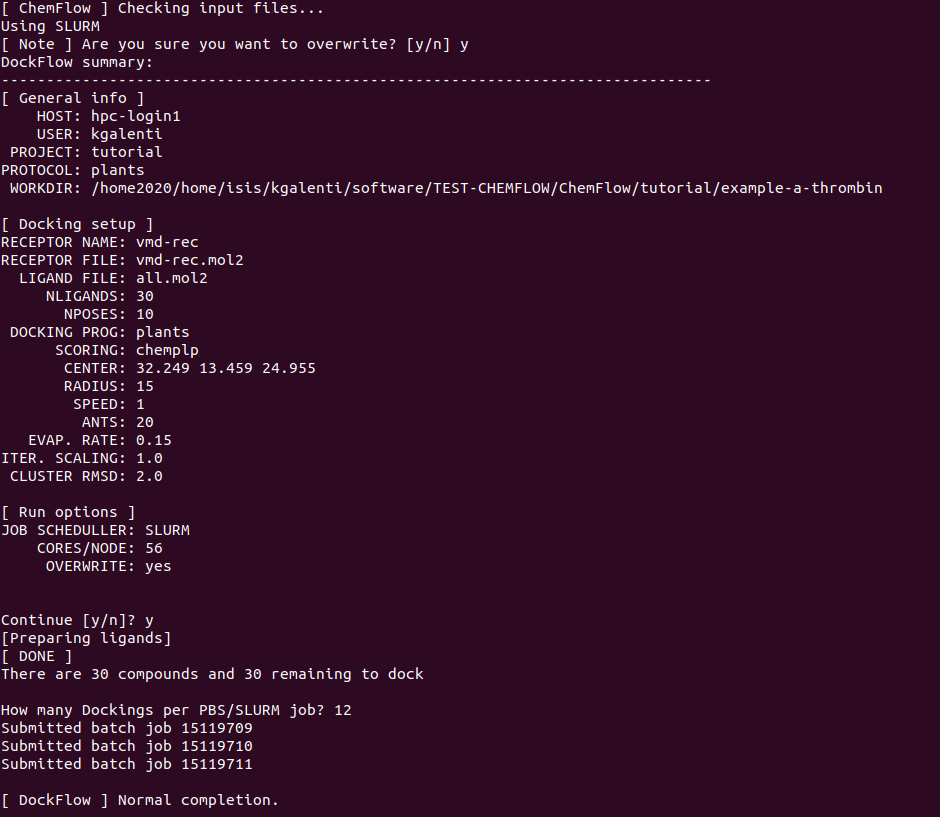

## Input validation, checkpointing & resume.
ChemFlow validates the input and generally warns you if something is missing. In addition it checkpoints the calculations and will resume from where it stopped, in case you run out of computer time, system crash, power failure or any other reason. If you want to rerun calculations on the same project+protocol you may choose <b>--overwrite</b>.

Give it a try ! Start a new docking protocol named "test", wait for a while and interrupt. Then relaunch with the same command, on your local machine.

>DockFlow -p tutorial --protocol test -r vmd-rec.mol2 -l all.mol2 --center  32.249 13.459 24.955 --radius 15

Interrupt (Cntrl+C), then launch again to see it resuming.

>DockFlow -p tutorial --protocol test -r vmd-rec.mol2 -l all.mol2 --center  32.249 13.459 24.955 --radius 15


## Relevant ChemFlow flags so far
| Flag | Description |
| --- | --- |
| -p,--project | Project name |
| --protocol   | Current protocol |
| -r | receptor filename (.mol2)  | 
| -l | ligand filename (.mol2) | 
| -dp | docking program
| -sf | scoring function
| --center | Docking center (XYZ |
| --radius | Search radius |
| --size | Search box dimentions |
|--slurm| Use the Slurm job Scheduller|
|--pbs| Use the PBS job Scheduller| 
|--overwrite| Overwrite (otherwise ChemFlow will resume calculations) |



## Step 4: Postprocess all the results
Docking generates several files for each complex and the big issue here is that each docking program organizes their results their own way.
To organize and standardize all results to the ChemFlow standands you should <b>--postprocess</b>.  Here, we decided to keep only the best 3 poses for each ligand (-n 3).

Each energy and structure will be extracted from it's folder and written into a single Structure file (docked_ligands.mol2) and a single Energy file (DockFlow.csv) containing the selected structures. 


>DockFlow -p tutorial --protocol plants -r vmd-rec.mol2 -l all.mol2 --postprocess --overwrite -n 3 

>DockFlow -p tutorial --protocol vina   -r vmd-rec.mol2 -l all.mol2 --postprocess -sf vina --overwrite -n 3 

>DockFlow -p tutorial --protocol qvina  -r vmd-rec.mol2 -l all.mol2 -sf vina -dp qvina --postprocess --archive --overwrite -n 3

>DockFlow -p tutorial --protocol smina  -r vmd-rec.mol2 -l all.mol2 -sf vinardo -dp smina --postprocess  --overwrite -n 3

### Step 4.1: Archive the folder with the docking results

DockFlow -p tutorial --protocol plants -r vmd-rec.mol2 -l all.mol2 --archive

Answer some questions...
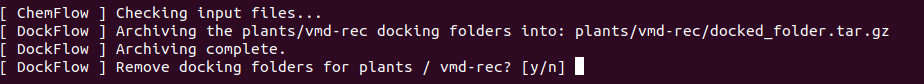

And you'll get an nicely organized folder with your <b>docked_ligands.mol2</b>

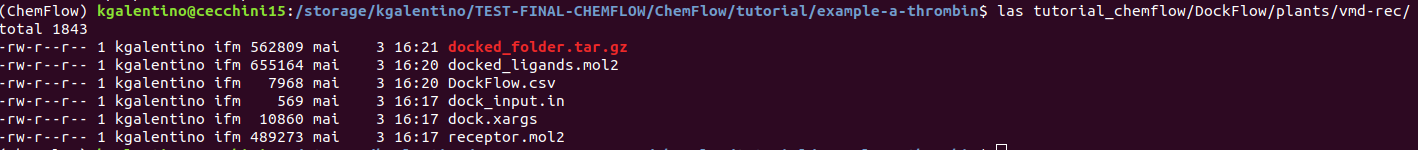


## Step 5: Run LigFlow to compute bcc or resp charges for your docked_ligands

Here, we compute bcc charges for the first 3 poses of each ligand we previously docked:

>LigFlow -p tutorial -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 

It will be computationally expensive, so we we recomend the users to use a cluster/supercomputer.
Remember to always provide an header file for running the workflow on a cluster/supercomputer.
If you have run the docking locally, remember to copy the tutorial_chemflow folder or docked_ligands.mol2 file in the new work directory of the cluster/supercomputer you are gonna use.

If you copy the docked_ligands.mol2 file then run:

>LigFlow -l docked_ligands.mol2 -p tutorial --bcc --slurm --header LigFlow.header

otherwise if you copied the directory of chemflow run:


>LigFlow -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -p tutorial --bcc --slurm --header LigFlow.header

## Step 6: Run ScoreFlow to rescore the previous doking poses for which we computed bcc charges (best 3 for each ligand)

Here, we only keep on with plants results (tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2).

Rescoring using MMGBSA method:
Currently we implemented 

### Locally:
ScoreFlow -p tutorial --protocol mmgbsa -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --overwrite --bcc --write-only

ScoreFlow -p tutorial --protocol mmgbsa -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --overwrite --bcc --run-only

ScoreFlow -p tutorial --protocol mmgbsa_md       -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --md --write-only --overwrite

ScoreFlow -p tutorial --protocol mmgbsa_md       -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --md --run-only --overwrite


### Relevant ScoreFlow flags
| Flag | Description |
| --- | --- | 
| -sf |  Scoring Function |
| --md | Molecular Dynamics simulation | 
| --water | Solvate the system and add counter-ions | 
| --bcc | AM1-BCC charges | 
| --resp | RESP charges (requires Gaussian 09+) |  

For each of these commands you will be asked:

* Are you sure you want to OVERWRITE? > y
* Continue? > y

Same as for DockFlow, if you have access to a cluster, use the --slurm or --pbs flag.

Using a pbs cluster:
++++++++++++++++++++

>ScoreFlow -p tutorial --protocol mmgbsa          -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/receptor/docked_ligands.mol2 -sf mmgbsa              --pbs --overwrite

>ScoreFlow -p tutorial --protocol mmgbsa_md       -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/receptor/docked_ligands.mol2 -sf mmgbsa --md         --pbs --overwrite
   

Step 6: Postprocess the results
-------------------------------
When you are done, you can postprocess (--postprocess) the results. This will generate a single **ScoreFlow.csv** file, containing the rescoring energies.

>ScoreFlow -p tutorial --protocol mmgbsa -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --postprocess

>ScoreFlow -p tutorial --protocol mmgbsa_md -r receptor.pdb -l tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 -sf mmgbsa --postprocess


## Step 7: Run ScoreFlow to rescore the previous docking poses on HPC

Always remember that to run on HPC you need to provide an header file, appropriate for the cluster/supercomputer.

Copy the tutorial_chemflow folder in the work directory of the cluster/supercomputer you are gonna use.

### MMGBSA rescoring in explicit solvent:

ScoreFlow --project tutorial --protocol mmgbsa_docked -sf mmgbsa --receptor receptor.pdb --ligand tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2  --water --slurm --header ScoreFlow.header

### MMGBSA rescoring in implicit solvent:

ScoreFlow --project tutorial --protocol mmgbsa_docked -sf mmgbsa --receptor receptor.pdb --ligand tutorial_chemflow/DockFlow/plants/vmd-rec/docked_ligands.mol2 --slurm --header ScoreFlow.header

<div class="alert-warning">
    
## Advanced

</div>

Using the *--write-only* flag, all input files will be written in tutorial_chemflow/ScoreFlow/mmgbsa_md/receptor/:

System Setup: You can modify the system setup (tleap_implicit.in file or tleap_salt-tot.in) inside your job.
    Simulation protocol: The procedures for each protocol can also be modified, the user must review "ScoreFlow.run.template".
    Run input files (Amber and MMGBSA): Namely min1.in, heat.in, equil.in, md.in ... can also be manually modified at wish :)
    After the modifications, rerun ScoreFlow using *--run-only*.
